In [1]:
%matplotlib inline

import operator, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import cycle, islice
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('data/original_watson_dataset.csv')
df.head()

,Unnamed: 0,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


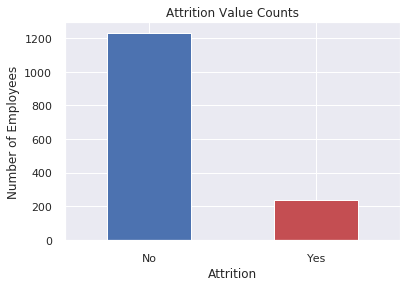

In [167]:
attrition_count = df.Attrition.value_counts()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = attrition_count.plot.bar(color=my_colors)
plt.title('Attrition Value Counts')
plt.xlabel('Attrition')
plt.ylabel('Number of Employees')
ax.set_xticklabels(['No', 'Yes'],rotation = 0);

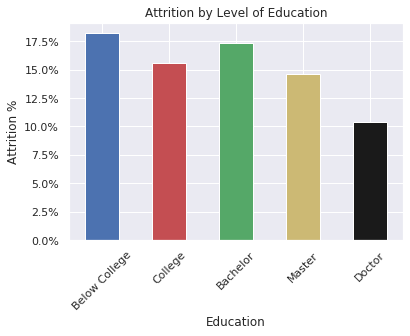

In [156]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
ed_info = df.groupby('Education', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
ed_info['AttrRatio'] = ed_info.Attrition/ed_info.EmployeeCount

my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = ed_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Level of Education')
plt.xlabel('Education')
plt.ylabel('Attrition %')
edulabels = ('Below College', 'College', 'Bachelor', 'Master', 'Doctor')
ax.set_xticklabels(edulabels, rotation = 45)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]);

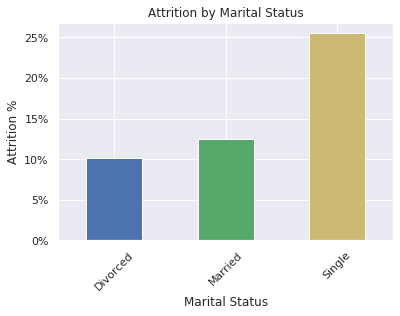

In [159]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
mar_info = df.groupby('MaritalStatus', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
mar_info['AttrRatio'] = mar_info.Attrition/mar_info.EmployeeCount
mar_info.to_csv('data/mar_info.csv')
my_colors = list(islice(cycle(['b', 'g', 'y', 'k']), None, len(df)))
ax = mar_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Attrition %')
marlabels = ('Divorced', 'Married', 'Single')
ax.set_xticklabels(marlabels, rotation = 45)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

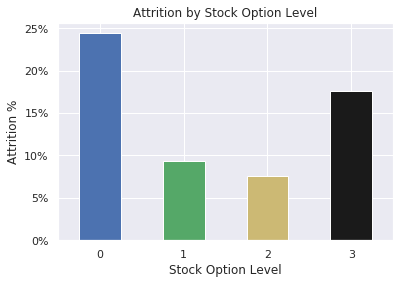

In [158]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
stock_info = df.groupby('StockOptionLevel', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
stock_info['AttrRatio'] = stock_info.Attrition/stock_info.EmployeeCount
stock_info
my_colors = list(islice(cycle(['b', 'g', 'y', 'k']), None, len(df)))
ax = stock_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Stock Option Level')
plt.xlabel('Stock Option Level')
plt.ylabel('Attrition %')
ax.set_xticklabels([0,1,2,3], rotation = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

In [3]:
# feature engineering
df = df.iloc[:,1:].drop(['MonthlyRate', 'HourlyRate', 'EmployeeNumber',
                         'EmployeeCount', 'Gender', 'Over18', 'StandardHours'], axis=1)
df['ResearchTravelRare'] = ((df.BusinessTravel == 'Travel_Rarely') & (df.Department == 'Research & Development'))\
.astype(int)
df['YearsNoChange'] = df[["YearsInCurrentRole", "YearsSinceLastPromotion", 'YearsWithCurrManager']].min(axis=1)

In [4]:
# take features with autoviml feature selection
remove = ['Attrition', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager']
features = df.drop(remove, axis=1)
features_dum = pd.get_dummies(features)
target = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)

X_train, X_test, y_train, y_test = train_test_split(features_dum, target, 
                                                    test_size = 0.2, random_state=99)

In [5]:
# create model
ratio_wei = {1 : 2, 0 : 1}
log = LogisticRegression(C=20, solver='liblinear', max_iter=3000, class_weight=ratio_wei)

In [8]:
kf = KFold(n_splits=5, random_state=99)
model = log
attrib = features_dum

print('F1 Weighted:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='f1_weighted')))
print('Precision:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='precision')))
print('Recall:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='recall')))
print('ROC-AUC:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='roc_auc')))

F1 Weighted: 0.8620908267213865
Precision: 0.5794471544715447
Recall: 0.5768463524704353
ROC-AUC: 0.8362105232574196


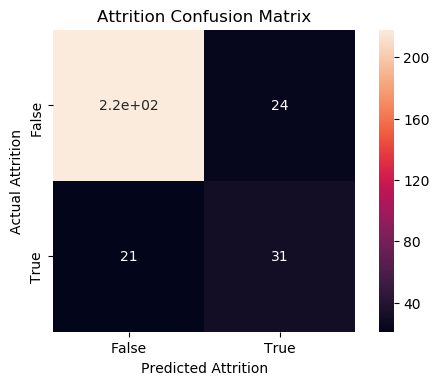

In [7]:
predict = log.fit(X_train,y_train).predict(X_test)
confusion = confusion_matrix(y_test, predict)
plt.figure(dpi=100)
sns.heatmap(confusion[::-1], annot=True, square=True, 
            xticklabels = ['False', 'True'], yticklabels=['True', 'False'])
plt.xlabel('Predicted Attrition')
plt.ylabel('Actual Attrition')
plt.ylim((0,2))
plt.title('Attrition Confusion Matrix');

Logistic Regression Model best F1 score 0.593 at prob decision threshold >= 0.345


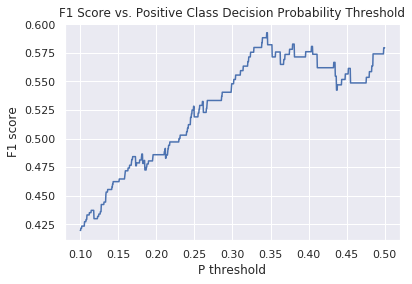

In [7]:
sns.set()

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = log.fit(X_train,y_train).predict_proba(X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

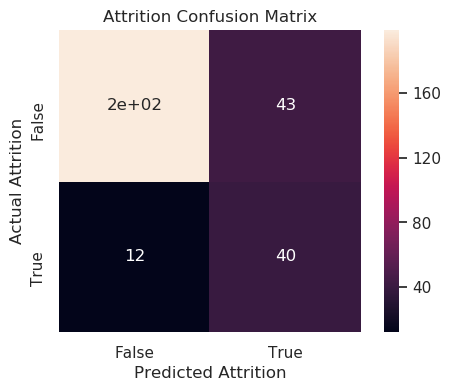

In [8]:
pred_thres = model_val_probs >= 0.345
confusion2 = confusion_matrix(y_test, pred_thres)
plt.figure(dpi=100)
sns.heatmap(confusion2[::-1], annot=True, square=True, 
            xticklabels = ['False', 'True'], yticklabels=['True', 'False'])
plt.xlabel('Predicted Attrition')
plt.ylabel('Actual Attrition')
plt.ylim((0,2))
plt.title('Attrition Confusion Matrix');

8


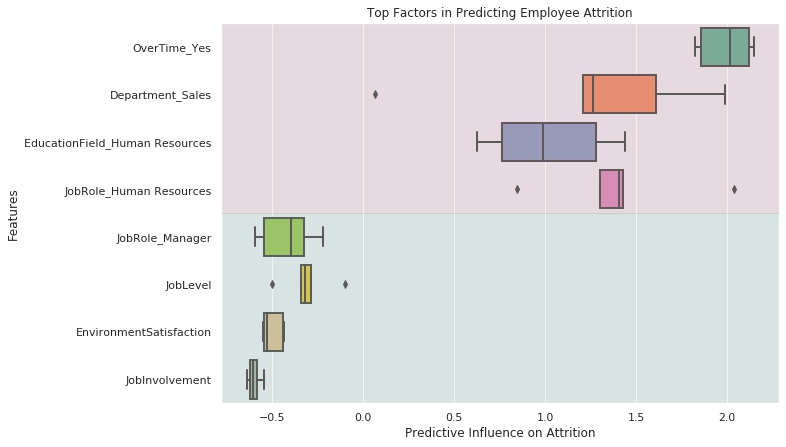

In [15]:
# plot feature coefficient variance
cv_results = cross_validate(log, X_train, y_train, cv=5, return_estimator=True)

feat_coef = []
for model in cv_results['estimator']:
    feat_coef.append(list(zip(X_train.columns, model.coef_[0])))
flat_feat = [item for sublist in feat_coef for item in sublist]

d = defaultdict(list)
for k, v in flat_feat:
    d[k].append(v)
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
x = ([feat[0] for feat in sorted_d[:2]]
     + [feat[0] for feat in sorted_d[4:6]]
    + [feat[0] for feat in sorted_d[-4:]])
y = ([coef[1] for coef in sorted_d[:2]]
    + [coef[1] for coef in sorted_d[4:6]]
    + [coef[1] for coef in sorted_d[-4:]])

print(len(y))

labels = ['Overtime', 'Sales Dept', 'Single', 'HR Role', 'Life Sciences Ed.',
          'Env. Satisfaction', 'Job Involvement', 'Manager Role']
plt.figure(figsize=(10, 7))
ax = sns.boxplot(y,x, linewidth=2, palette='Set2')
# ax.set_xticklabels(labels)
# ax.axhline(3.5, ls='--', c='r')
ax.axhspan(ymin=3.5, ymax=7.5,color='g', alpha=0.1)
ax.axhspan(ymin=-0.5, ymax=3.5,color='r', alpha=0.1)
plt.title('Top Factors in Predicting Employee Attrition')
plt.xlabel('Predictive Influence on Attrition')
plt.ylabel('Features');